#Data Upload

In [ ]:
# Tải file zip từ GitHub
!wget https://github.com/YingtongDou/CARE-GNN/raw/master/data/Amazon.zip -O /content/Amazon.zip

import zipfile
import os
import scipy.io
import numpy as np
import scipy.sparse

target_path = "/content/Amazon.zip"
extract_path = "/content/Amazon"

with zipfile.ZipFile(target_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Amazon.zip extracted.")

files = os.listdir(extract_path)
print("Extracted files:", files)

data_file = None
mat_data = {}

for file in files:
    if file.endswith(".mat"):
        data_file = os.path.join(extract_path, file)
        break

if data_file:
    mat = scipy.io.loadmat(data_file)
    print("MAT file keys:", mat.keys())

    for key in mat:
        if not key.startswith('__'):
            data = mat[key]
            if scipy.sparse.issparse(data):
                data = data.toarray() #Chuyển dữ liệu từ dạng sparse(ma trận thưa-không chứa số 0) về dense(ma trận đầy đủ-có số 0) sử dụng hàm toarray nhằm mục đích tính toán, vẽ biểu đồ#
            mat_data[key] = data
            print(f"Key: {key}, Shape: {data.shape}, Type: {type(data)}")
else:
    print("No MAT file found")

features = mat_data.get('features', None)
labels = mat_data.get('label', None)

if labels is not None and labels.shape[0] == 1:
    labels = labels.ravel()

print("Features shape:", features.shape if features is not None else "None")
print("Labels shape:", labels.shape if labels is not None else "None")


--2025-05-15 07:26:14--  https://github.com/YingtongDou/CARE-GNN/raw/master/data/Amazon.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/YingtongDou/CARE-GNN/master/data/Amazon.zip [following]
--2025-05-15 07:26:14--  https://raw.githubusercontent.com/YingtongDou/CARE-GNN/master/data/Amazon.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26122297 (25M) [application/zip]
Saving to: ‘/content/Amazon.zip’

/content/Amazon.zip 100%[===================>]  24.91M  --.-KB/s    in 0.1s    

2025-05-15 07:26:15 (249 MB/s) - ‘/content/Amazon.zip’ saved [26122297/26122297]

Amazon.zip extracted.
Ext

#Visualization

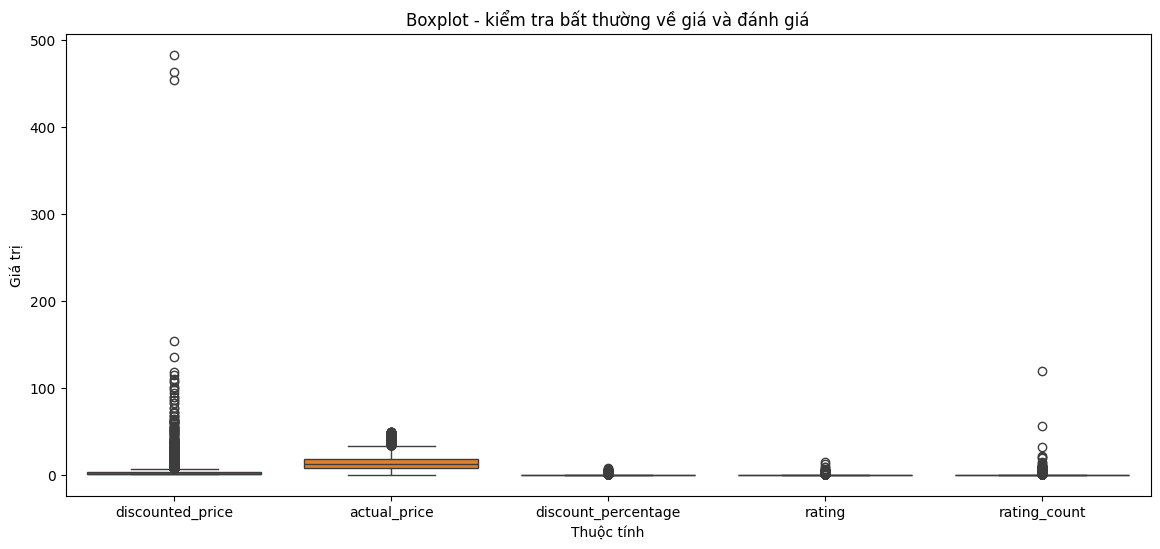

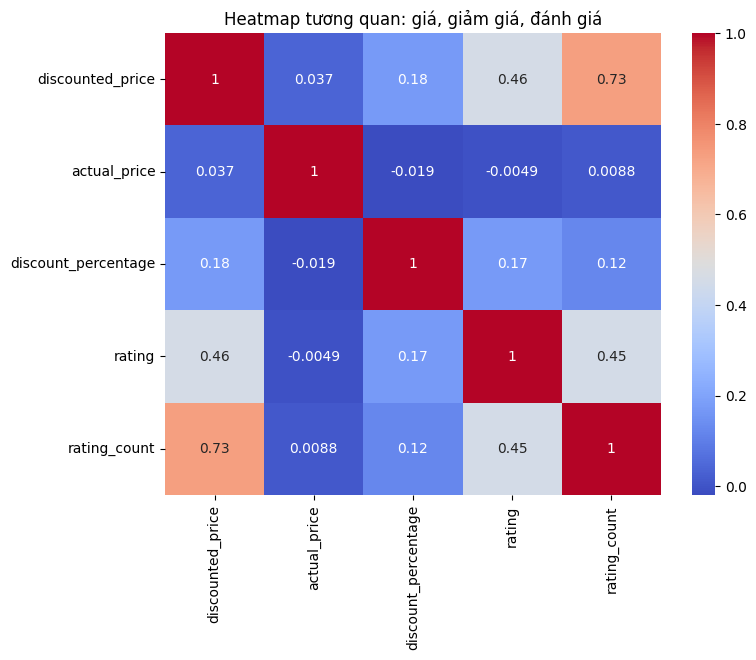

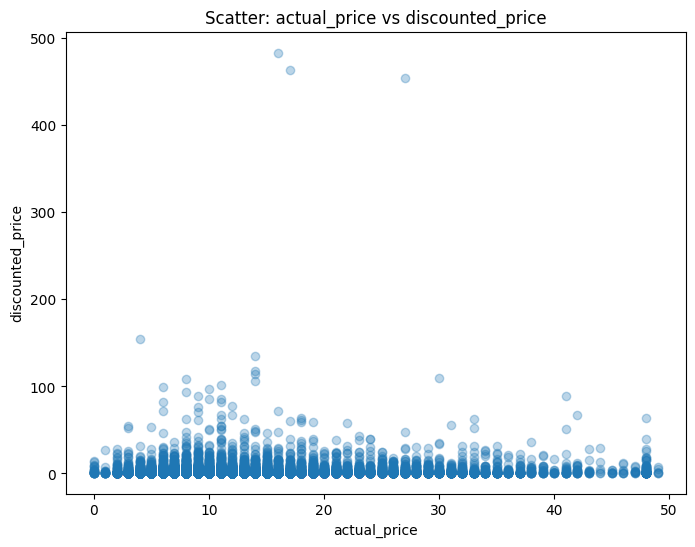

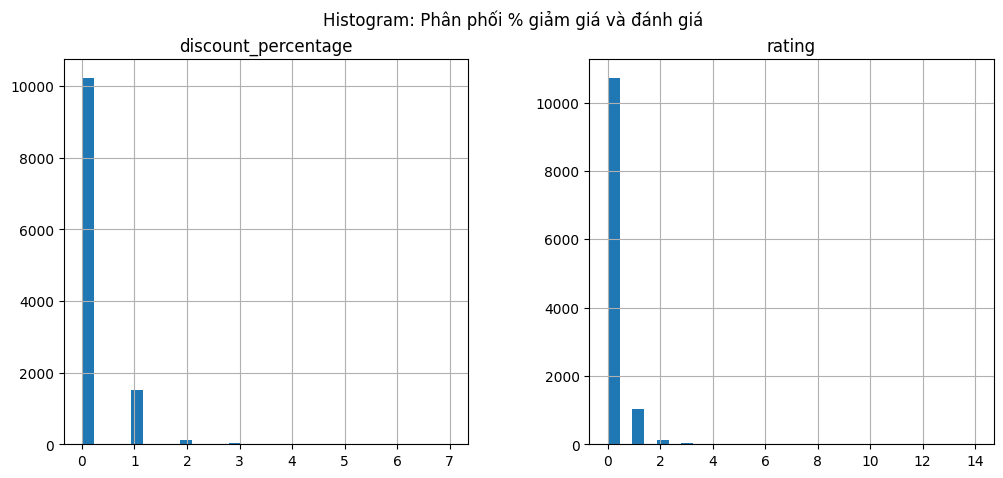

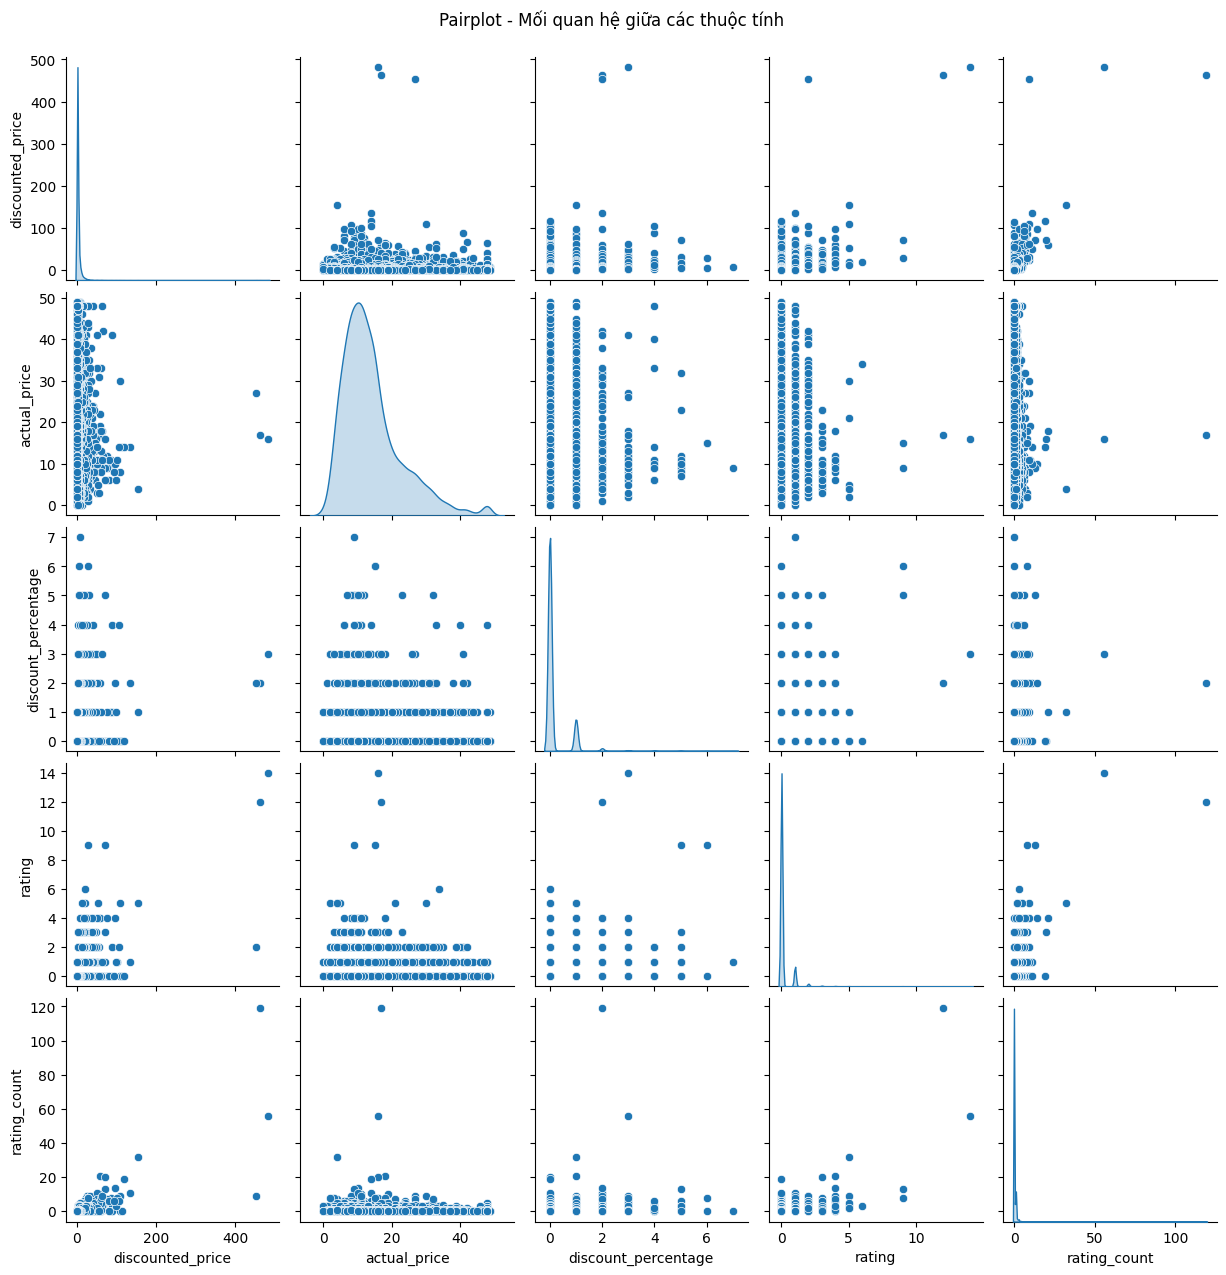

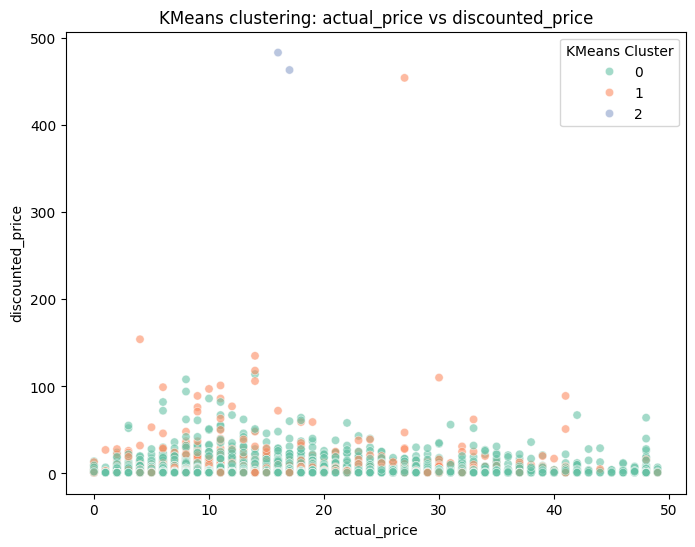


Số lượng điểm nghi ngờ (outliers) theo DBSCAN: 150


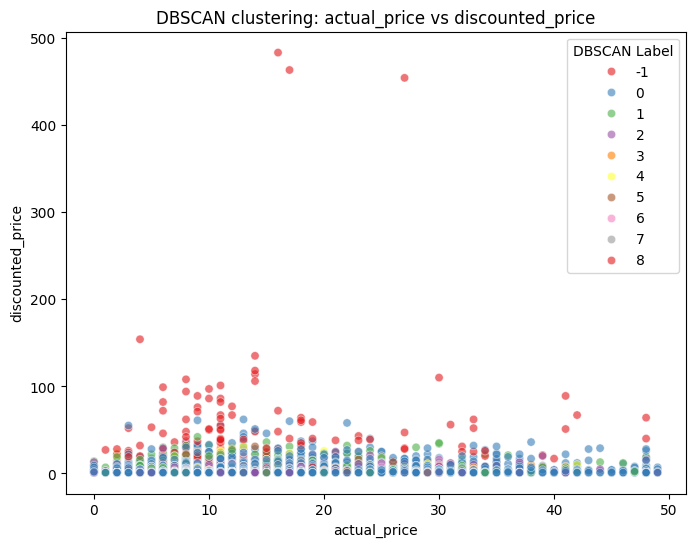


Tổng quan dữ liệu liên quan anomaly:
                     min    max       mean       std  unique_values  \
discounted_price     1.0  483.0   3.326189  9.887330             81   
actual_price         0.0   49.0  14.102395  8.681367             50   
discount_percentage  0.0    7.0   0.165690  0.458903              8   
rating               0.0   14.0   0.126842  0.460154             10   
rating_count         0.0  119.0   0.273359  1.470252             20   

                     most_common  
discounted_price             1.0  
actual_price                11.0  
discount_percentage          0.0  
rating                       0.0  
rating_count                 0.0  

Phân tích giá trị phổ biến/ít gặp nhất:

Cột discounted_price:
- Giá trị phổ biến nhất: 1.0 (7112 lần)
- Giá trị ít gặp nhất: 135.0 (1 lần)

Cột actual_price:
- Giá trị phổ biến nhất: 11.0 (778 lần)
- Giá trị ít gặp nhất: 44.0 (6 lần)

Cột discount_percentage:
- Giá trị phổ biến nhất: 0.0 (10241 lần)
- Giá trị ít gặp nhất:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# ====== Tạo DataFrame ======
selected_cols = ['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count']
df_features = pd.DataFrame(features[:, :len(selected_cols)], columns=selected_cols)

# Gán thêm cột nhãn nếu có
if labels is not None:
    df_features['label'] = labels

# ====== Chọn các cột liên quan đến anomaly detection ======

# 1. BOXPLOT - kiểm tra giá trị bất thường
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_features[selected_cols])
plt.title('Boxplot - kiểm tra bất thường về giá và đánh giá')
plt.xlabel("Thuộc tính")
plt.ylabel("Giá trị")
plt.show()

# 2. HEATMAP - tương quan giữa các yếu tố tài chính
corr_matrix = df_features[selected_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap tương quan: giá, giảm giá, đánh giá')
plt.show()

# 3. SCATTER PLOT - actual_price vs discounted_price
plt.figure(figsize=(8, 6))
plt.scatter(df_features['actual_price'], df_features['discounted_price'], alpha=0.3)
plt.title("Scatter: actual_price vs discounted_price")
plt.xlabel("actual_price")
plt.ylabel("discounted_price")
plt.show()

# 4. HISTOGRAM - phân phối discount và rating
df_features[['discount_percentage', 'rating']].hist(figsize=(12, 5), bins=30)
plt.suptitle("Histogram: Phân phối % giảm giá và đánh giá")
plt.show()

# 5. PAIRPLOT - xem mối quan hệ giữa các thuộc tính
sns.pairplot(df_features[selected_cols], diag_kind="kde")
plt.suptitle("Pairplot - Mối quan hệ giữa các thuộc tính", y=1.02)
plt.show()

# ====== Tiền xử lý: chuẩn hóa dữ liệu số ======
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features[selected_cols])

# 6. KMEANS clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_features['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_features['actual_price'],
    y=df_features['discounted_price'],
    hue=df_features['kmeans_cluster'],
    palette='Set2',
    alpha=0.6
)
plt.title("KMeans clustering: actual_price vs discounted_price")
plt.xlabel("actual_price")
plt.ylabel("discounted_price")
plt.legend(title="KMeans Cluster")
plt.show()

# 7. DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=10)
df_features['dbscan_label'] = dbscan.fit_predict(X_scaled)

outliers = df_features[df_features['dbscan_label'] == -1]
print(f"\nSố lượng điểm nghi ngờ (outliers) theo DBSCAN: {len(outliers)}")

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_features['actual_price'],
    y=df_features['discounted_price'],
    hue=df_features['dbscan_label'],
    palette='Set1',
    alpha=0.6
)
plt.title("DBSCAN clustering: actual_price vs discounted_price")
plt.xlabel("actual_price")
plt.ylabel("discounted_price")
plt.legend(title="DBSCAN Label")
plt.show()

# 9. Tổng quan dataset (số lượng giá trị, trung bình, phổ biến nhất)
summary = df_features[selected_cols].describe().T[['min', 'max', 'mean', 'std']]
summary['unique_values'] = df_features[selected_cols].nunique()
summary['most_common'] = df_features[selected_cols].mode().iloc[0]
print("\nTổng quan dữ liệu liên quan anomaly:")
print(summary)

# 10. Phân tích thuộc tính nào thường có giá trị bất thường
print("\nPhân tích giá trị phổ biến/ít gặp nhất:")
for col in selected_cols:
    counts = df_features[col].value_counts()
    print(f"\nCột {col}:")
    print(f"- Giá trị phổ biến nhất: {counts.idxmax()} ({counts.max()} lần)")
    print(f"- Giá trị ít gặp nhất: {counts.idxmin()} ({counts.min()} lần)")


In [ ]:
print(df_features.columns.tolist())


#Data Preprocessing


In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install torch_geometric --extra-index-url https://data.pyg.org/whl/torch-2.0.0+cu118.html

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.impute import KNNImputer
from collections import Counter

# Autoencoder training function
#Xử lý nhiễu, dư thừa dữ liệu. Encoder để nén lại dữ liệu, loại bỏ dl dư thừa, nhiễu, chọn những cái tốt nhất, sau đó là Decoder tái tạo lại bộ dữ liệu từ những dữ liệu tốt nhất#
def train_autoencoder(features, encoding_dim=10, epochs=100, lr=0.001, patience=5):
    class Autoencoder(nn.Module):
        def __init__(self, input_dim, encoding_dim):
            super().__init__()
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, 256), nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Linear(256, 128), nn.LeakyReLU(0.2),
                nn.Linear(128, encoding_dim)
            )
            self.decoder = nn.Sequential(
                nn.Linear(encoding_dim, 128), nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Linear(128, 256), nn.LeakyReLU(0.2),
                nn.Linear(256, input_dim)
            )

        def forward(self, x):
            return self.decoder(self.encoder(x))

    model = Autoencoder(features.shape[1], encoding_dim)
    criterion = nn.MSELoss()#đo sai lệch giữa đầu vào và đầu ra, dùng để biết mô hình đang học tốt không (đầu ra càng giống đầu vào càng tốt)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)#chống overfitting#
    train_data = torch.FloatTensor(features)#chuyển dữ liệu của features sang  dạng PyTorch có thể xử lý#
    best_loss = float('inf')#Dùng để kiểm soát quá trình học: nếu mô hình không tốt lên nữa thì sẽ dừng
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_data)
        loss = criterion(outputs, train_data)
        loss.backward()
        optimizer.step()

        if loss < best_loss:
            best_loss = loss
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.eval()
    with torch.no_grad():
        reconstructed = model(train_data).numpy()

    return reconstructed

# Data preprocessing function (outliers retained)
def preprocess_data(features, labels, encoding_dim=10, n_neighbors=5, output_path='preprocessed_data.csv'):
    print("\n=== Starting Preprocessing ===")

    # Convert sparse matrix to dense if necessary
    if hasattr(features, "toarray"):
        features = features.toarray()
    print(f"Dense conversion: {features.shape}")

    # KNN Imputation for missing values
    #Thay thế giá trị thiếu bằng giá trị trung bình của những điểm gần nhất
    features = KNNImputer(n_neighbors=min(n_neighbors, max(1, features.shape[0]-1))).fit_transform(features)
    print(f"After KNN imputation: {features.shape}")

    # Log transformation to reduce skewness
    #Giảm độ lệch của dữ liệu
    features = np.clip(features, a_min=1e-6, a_max=None)
    features = FunctionTransformer(np.log1p).fit_transform(features)
    print(f"After log transform: {features.shape}")

    # Robust scaling to mitigate outliers
    #Loại bỏ các giá trị ngoại lai
    features = RobustScaler(quantile_range=(5, 95)).fit_transform(features)
    print(f"After scaling: {features.shape}")

    # Feature extraction using autoencoder
    #trích chọn đặc trưng
    print("\nFeature Extraction:")
    features = train_autoencoder(features, encoding_dim)
    print(f"Final feature shape: {features.shape}")

    # Save processed data
    pd.DataFrame(np.hstack([features, labels.reshape(-1,1)]),
                columns=[f'feat_{i}' for i in range(features.shape[1])]+['label']
                ).to_csv(output_path, index=False)

    print("\n=== Preprocessing Complete ===")
    return features, labels

features, labels = preprocess_data(features, labels)


=== Starting Preprocessing ===
Dense conversion: (11944, 25)
After KNN imputation: (11944, 25)
After log transform: (11944, 25)
After scaling: (11944, 25)

Feature Extraction:
Final feature shape: (11944, 25)

=== Preprocessing Complete ===


#Model Implementation + SHAP

In [ ]:
!pip install optuna

Running GNN pipeline with SHAP...
Loading data...
Setting up model...
Training new model...
Epoch 0/49:
  Loss: 1.6774
  Train - Acc: 0.8730, F1: 0.8961, Recall: 0.8730
  Val   - Acc: 0.8889, F1: 0.9096, Recall: 0.8889
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
Epoch 10/49:
  Loss: 1.0370
  Train - Acc: 0.9579, F1: 0.9517, Recall: 0.9579
  Val   - Acc: 0.9637, F1: 0.9590, Recall: 0.9637
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
Epoch 20/49:
  Loss: 0.9991
  Train - Acc: 0.9592, F1: 0.9536, Recall: 0.9592
  Val   - Acc: 0.9648, F1: 0.9597, Recall: 0.9648
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10


  0%|          | 0/5 [00:00<?, ?it/s]


SHAP Feature Importance Table:
    Feature  Importance
0    feat_2    0.046222
1   feat_11    0.013299
2   feat_15    0.012095
3    feat_5    0.007930
4   feat_22    0.005937
5    feat_7    0.005149
6   feat_14    0.004912
7    feat_4    0.004776
8    feat_1    0.004007
9   feat_18    0.002996
10   feat_8    0.002715
11  feat_23    0.002414
12  feat_10    0.002225
13   feat_3    0.002185
14  feat_21    0.002102
15  feat_17    0.002036
16  feat_16    0.001702
17   feat_6    0.001693
18  feat_20    0.001644
19  feat_13    0.001476
SHAP analysis completed successfully.


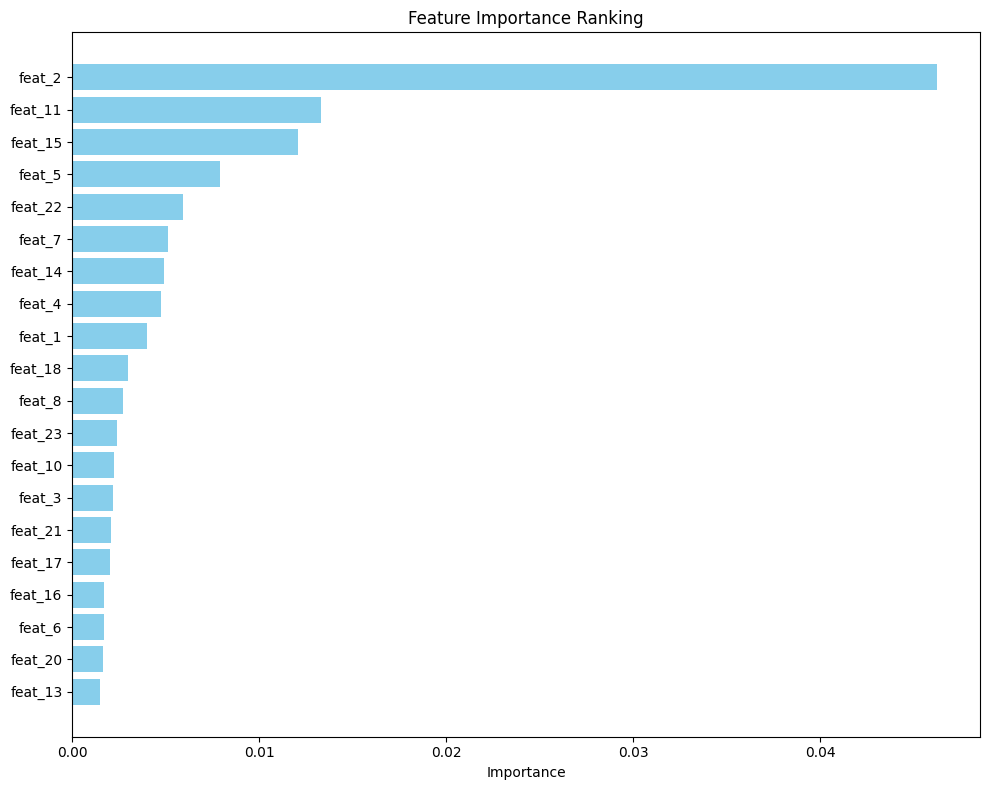

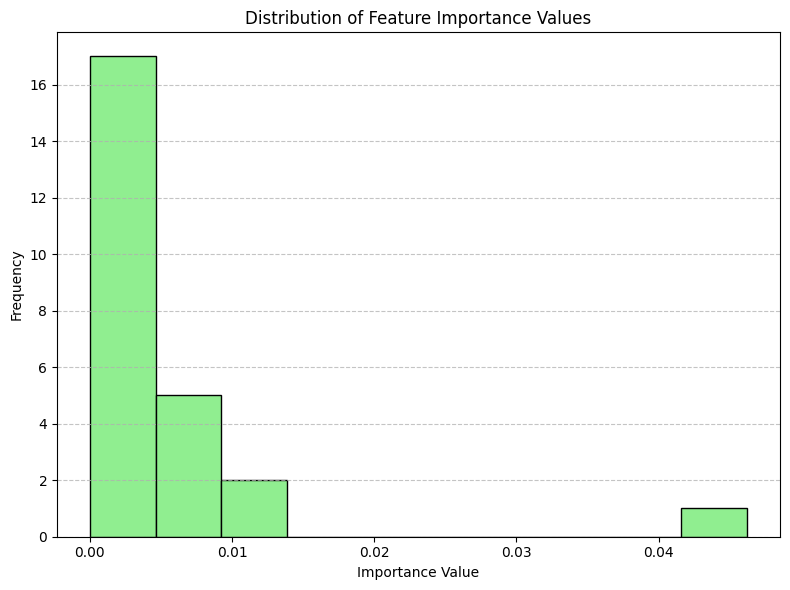

Analyzing edge importance with EdgeSHAPer approach...

Edge Importance Table:
     Edge    Importance
0    6-13  2.337591e-09
1    13-6  1.628282e-09
2    12-0  1.501447e-09
3    6-10  7.695635e-10
4     4-9  4.547474e-10
5   13-14  2.540861e-10
6    14-9  2.340869e-10
7    10-2  2.259524e-10
8     7-2  1.906398e-10
9     4-0  1.274457e-10
10    6-6  0.000000e+00
11    4-4  0.000000e+00
12    9-9  0.000000e+00
13    8-8  0.000000e+00
14    7-7  0.000000e+00
15    2-2  0.000000e+00
16    3-3  0.000000e+00
17    4-4  0.000000e+00
18    5-5  0.000000e+00
19  13-13  0.000000e+00
Pipeline completed!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, mean_squared_error, mean_absolute_error
import warnings
import traceback
import shap
import matplotlib.pyplot as plt
from torch.amp import autocast, GradScaler
import scipy.io
import numpy as np
warnings.filterwarnings("ignore")
def load_data_mat(mat_file_path, feature_key='features', label_key='label'):
    mat = scipy.io.loadmat(mat_file_path)
    features = mat[feature_key]
    labels = mat[label_key]
    if labels.ndim > 1:
        labels = labels.ravel()
    if hasattr(features, "todense"):
        features = features.todense()
    feature_names = [f"feat_{i}" for i in range(features.shape[1])]

    return np.array(features), np.array(labels), feature_names

def create_graph(features, labels, n_neighbors=5, feature_names=None):
    """Tạo đồ thị từ dữ liệu dạng bảng sử dụng k-NN"""
    #Visulize dữ liệu dưới dạng biểu đồ
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(features)
    knn_adj = nbrs.kneighbors_graph(features, mode='connectivity')
    edge_index = np.array(knn_adj.nonzero())
    edge_index = torch.tensor(edge_index, dtype=torch.long)

    x_tensor = torch.tensor(features, dtype=torch.float32)
    y_tensor = torch.tensor(labels, dtype=torch.long)

    # Phân chia tập dữ liệu: dùng 70% data đi train, xong 15% đi test, 15% còn lại đem đi valid. Là chia tệp thành 3 phần: 70-15-15
    num_nodes = x_tensor.shape[0]
    train_ratio, val_ratio = 0.7, 0.15
    num_train = int(train_ratio * num_nodes)
    num_val = int(val_ratio * num_nodes)

    indices = torch.randperm(num_nodes)
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[indices[:num_train]] = True
    val_mask[indices[num_train:num_train + num_val]] = True
    test_mask[indices[num_train + num_val:]] = True

    # Tạo tên đặc trưng nếu không được cung cấp
    if feature_names is None:
        feature_names = [f'feat_{i}' for i in range(features.shape[1])]

    return Data(x=x_tensor, edge_index=edge_index, y=y_tensor,
                train_mask=train_mask, val_mask=val_mask, test_mask=test_mask), feature_names
#Học được biểu diễn tốt của từng nút (giao dịch) bằng mô hình kết hợp GCN + GAT → giúp phân biệt gian lận và không gian lận.
class HybridGATGCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=2, dropout=0.5):
        super(HybridGATGCN, self).__init__()
        self.dropout = dropout

        self.gcn1 = GCNConv(in_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.gat1 = GATConv(hidden_dim, hidden_dim, heads=heads, concat=False, dropout=dropout)

        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.gat2 = GATConv(hidden_dim, out_dim, heads=heads, concat=False, dropout=dropout)
#Tăng khả năng phát hiện bằng data augmentation (bổ sung nhiễu) để mô hình không bị "học vẹt".
    def forward(self, x, edge_index):
        x = self.gcn1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat1(x, edge_index)

        x = F.relu(x)
        x = self.gcn2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)

        return F.log_softmax(x, dim=1)
#Biểu diễn các giao dịch như một đồ thị (nút là giao dịch, cạnh là quan hệ giữa chúng: cùng tài khoản, địa điểm, thời gian, v.v.).
def augment_graph(data, noise_level=0.1, drop_edge_rate=0.2):
    x_aug = data.x + noise_level * torch.randn_like(data.x)
    edge_index = data.edge_index.clone()
    num_edges = edge_index.shape[1]
    num_drop = int(drop_edge_rate * num_edges)

    if num_drop > 0:
        perm = torch.randperm(num_edges, device=edge_index.device)
        keep_edges = perm[num_drop:]
        edge_index_aug = edge_index[:, keep_edges]
    else:
        edge_index_aug = edge_index

    return Data(x=x_aug, edge_index=edge_index_aug, y=data.y,
                train_mask=data.train_mask, val_mask=data.val_mask, test_mask=data.test_mask)

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)
        sim = torch.mm(z1, z2.T) / self.temperature
        labels = torch.arange(z1.size(0)).to(z1.device)
        return F.cross_entropy(sim, labels)

#Dừng sớm tránh overfitting
class EarlyStopping:
    def __init__(self, patience=10, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def step(self, score, model=None):
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.counter = 0
            if model is not None:
                self.best_model_state = model.state_dict().copy()
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop
#Đo lường hiệu quả của mô hình
def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)

        correct = pred[mask] == data.y[mask]
        accuracy = correct.sum().item() / mask.sum().item()

        y_true = data.y[mask].cpu().numpy()
        y_pred = pred[mask].cpu().numpy()

        try:
            roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
        except:
            roc_auc = 0.0

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)

        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

    return accuracy, roc_auc, rmse, mae, f1, recall
#Học từ dữ liệu để tối ưu dự đoán
def train(model, data, epochs=100, lr=0.01, alpha=0.1, weight_decay=5e-4, patience=10, verbose=True):
    device = data.x.device
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=False)
    criterion = nn.CrossEntropyLoss()
    contrastive_loss_fn = ContrastiveLoss(temperature=0.5)
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    scaler = GradScaler('cuda' if torch.cuda.is_available() else 'cpu')

    history = {
        'loss': [], 'train_acc': [], 'val_acc': [],
        'train_f1': [], 'val_f1': [], 'train_recall': [], 'val_recall': []
    }

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            out = model(data.x, data.edge_index)
            loss_cls = criterion(out[data.train_mask], data.y[data.train_mask])

            data_aug = augment_graph(data)
            z1 = model(data.x, data.edge_index)
            z2 = model(data_aug.x, data_aug.edge_index)
            loss_contrastive = contrastive_loss_fn(z1[data.train_mask], z2[data.train_mask])

            loss = loss_cls + alpha * loss_contrastive

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_acc, train_roc_auc, train_rmse, train_mae, train_f1, train_recall = evaluate(model, data, data.train_mask)
        val_acc, val_roc_auc, val_rmse, val_mae, val_f1, val_recall = evaluate(model, data, data.val_mask)

        history['loss'].append(loss.item())
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['train_recall'].append(train_recall)
        history['val_recall'].append(val_recall)

        scheduler.step(val_f1)

        if early_stopping.step(val_f1, model):
            if verbose:
                print(f'Early stopping at epoch {epoch}')
            model.load_state_dict(early_stopping.best_model_state)
            break

        if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
            print(f'Epoch {epoch}/{epochs-1}:')
            print(f'  Loss: {loss.item():.4f}')
            print(f'  Train - Acc: {train_acc:.4f}, F1: {train_f1:.4f}, Recall: {train_recall:.4f}')
            print(f'  Val   - Acc: {val_acc:.4f}, F1: {val_f1:.4f}, Recall: {val_recall:.4f}')

    return model, history
#Check xem độ chính xác, sai lệch của mô hình sau khi train
def create_simplified_graph(data, max_nodes=20):
    cpu_data = data.cpu()

    actual_max_nodes = min(max_nodes, cpu_data.x.shape[0])

    if hasattr(cpu_data, 'test_mask') and cpu_data.test_mask.sum() > 0:
        test_indices = torch.where(cpu_data.test_mask)[0]
        if len(test_indices) > actual_max_nodes:
            indices = test_indices[:actual_max_nodes]
        else:
            remaining = actual_max_nodes - len(test_indices)
            train_indices = torch.where(cpu_data.train_mask)[0]
            if len(train_indices) > remaining:
                train_indices = train_indices[:remaining]
            indices = torch.cat([test_indices, train_indices])
    else:
        indices = torch.randperm(cpu_data.x.shape[0])[:actual_max_nodes]

    x_subset = cpu_data.x[indices].clone()
    y_subset = cpu_data.y[indices].clone()

    features_np = x_subset.numpy()
    n_neighbors = max(1, min(3, len(indices)-1))

    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean').fit(features_np)
    knn_adj = nbrs.kneighbors_graph(features_np, mode='connectivity')
    edge_index_new = np.array(knn_adj.nonzero())
    edge_index_new = torch.tensor(edge_index_new, dtype=torch.long)

    self_loops = torch.stack([torch.arange(len(indices)), torch.arange(len(indices))], dim=0)
    edge_index_new = torch.cat([edge_index_new, self_loops], dim=1)

    test_mask = torch.ones(len(indices), dtype=torch.bool)

    return Data(
        x=x_subset,
        edge_index=edge_index_new,
        y=y_subset,
        test_mask=test_mask
    )

def analyze_with_shap(model, data, feature_names):
    print("Analyzing model with SHAP...")

    model = model.cpu()
    model.eval()

    try:
        simple_data = create_simplified_graph(data.cpu(), max_nodes=20)

        total_nodes = simple_data.x.shape[0]
        if total_nodes < 5:
            print("Not enough nodes for SHAP analysis.")
            return False, None

        n_background = min(10, total_nodes // 2)
        n_sample = min(5, total_nodes // 2)

        background_indices = torch.randperm(total_nodes)[:n_background]
        sample_indices = torch.randperm(total_nodes)[:n_sample]

        background_data = simple_data.x[background_indices].numpy()
        sample_features = simple_data.x[sample_indices].numpy()

        def model_predict(x):
            with torch.no_grad():
                if isinstance(x, np.ndarray) and len(x) > 0:
                    try:
                        x_tensor = torch.tensor(x, dtype=torch.float32)

                        edge_index = simple_data.edge_index

                        max_node_idx = x_tensor.shape[0] - 1
                        valid_edges = (edge_index[0] <= max_node_idx) & (edge_index[1] <= max_node_idx)
                        valid_edge_index = edge_index[:, valid_edges]

                        if valid_edge_index.shape[1] == 0:
                            node_indices = torch.arange(x_tensor.shape[0])
                            valid_edge_index = torch.stack([node_indices, node_indices], dim=0)

                        out = model(x_tensor, valid_edge_index)
                        probs = torch.exp(out).cpu().numpy()

                        if probs.shape[1] == 2:
                            return probs[:, 1]
                        else:
                            return [probs[:, i] for i in range(probs.shape[1])]
                    except Exception as e:
                        print(f"Error in model prediction: {str(e)}")
                        num_classes = len(np.unique(simple_data.y.numpy()))
                        if num_classes == 2:
                            return np.zeros(x.shape[0])
                        else:
                            return [np.zeros(x.shape[0]) for _ in range(num_classes)]
                else:
                    return np.array([])

        explainer = shap.KernelExplainer(
            model_predict,
            background_data,
            nsamples=50,
            link="identity"
        )

        shap_values = explainer.shap_values(
            sample_features,
            nsamples=100,
            l1_reg="num_features(10)"
        )

        if isinstance(shap_values, list):
            feature_importance = np.zeros(len(feature_names))
            for class_sv in shap_values:
                feature_importance += np.abs(class_sv).mean(axis=0)
            feature_importance /= len(shap_values)
        else:
            feature_importance = np.abs(shap_values).mean(axis=0)

        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False).reset_index(drop=True)

        plt.figure(figsize=(12, 8))
        if isinstance(shap_values, list):
            shap.summary_plot(
                shap_values,
                sample_features,
                feature_names=feature_names,
                plot_size=(10, 6),
                show=False,
                max_display=min(20, len(feature_names))
            )
        else:
            shap.summary_plot(
                shap_values,
                sample_features,
                feature_names=feature_names,
                plot_size=(10, 6),
                show=False,
                max_display=min(20, len(feature_names))
            )

        plt.title("SHAP Feature Importance")
        plt.tight_layout()
        plt.savefig("shap_summary.png", dpi=300)
        plt.close()

        plt.figure(figsize=(12, 8))
        shap.summary_plot(
            shap_values,
            sample_features,
            feature_names=feature_names,
            plot_type="bar",
            show=False,
            max_display=min(20, len(feature_names))
        )
        plt.title("SHAP Feature Importance (Bar)")
        plt.tight_layout()
        plt.savefig("shap_bar.png", dpi=300)
        plt.close()

        print("\nSHAP Feature Importance Table:")
        print(importance_df.head(20))
        importance_df.to_csv("shap_importance.csv", index=False)

        print("SHAP analysis completed successfully.")
        return True, importance_df

    except Exception as e:
        print(f"Error in SHAP analysis: {str(e)}")
        traceback.print_exc()
        return False, None

def calculate_feature_importance(model, data, feature_names):
    print("Using improved permutation feature importance method...")

    cpu_model = model.cpu()
    cpu_data = data.cpu()
    cpu_model.eval()

    simple_data = create_simplified_graph(cpu_data, max_nodes=30)

    with torch.no_grad():
        out = cpu_model(simple_data.x, simple_data.edge_index)
        pred = out.argmax(dim=1)
        y_true = simple_data.y[simple_data.test_mask].cpu().numpy()
        y_pred = pred[simple_data.test_mask].cpu().numpy()

        baseline_acc = (pred[simple_data.test_mask] == simple_data.y[simple_data.test_mask]).float().mean().item()
        baseline_f1 = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)[2]

    importances_acc = []
    importances_f1 = []
    n_repeats = 3

    for i in range(simple_data.x.shape[1]):
        feature_acc_changes = []
        feature_f1_changes = []

        for _ in range(n_repeats):
            original_values = simple_data.x[:, i].clone()

            perm_idx = torch.randperm(simple_data.x.shape[0])
            simple_data.x[:, i] = simple_data.x[perm_idx, i]

            with torch.no_grad():
                out = cpu_model(simple_data.x, simple_data.edge_index)
                pred = out.argmax(dim=1)

                perm_acc = (pred[simple_data.test_mask] == simple_data.y[simple_data.test_mask]).float().mean().item()
                y_pred = pred[simple_data.test_mask].cpu().numpy()
                perm_f1 = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)[2]

            simple_data.x[:, i] = original_values

            feature_acc_changes.append(baseline_acc - perm_acc)
            feature_f1_changes.append(baseline_f1 - perm_f1)

        importances_acc.append(np.mean(feature_acc_changes))
        importances_f1.append(np.mean(feature_f1_changes))

    importances = (np.array(importances_acc) + np.array(importances_f1)) / 2

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances,
        'Importance_Acc': importances_acc,
        'Importance_F1': importances_f1
    })
    importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
    plt.title("Feature Importance (Improved Permutation Method)")
    plt.xlabel("Average Decrease in Performance Metrics when Feature is Permuted")
    plt.tight_layout()
    plt.savefig("feature_importance_permutation.png", dpi=300, bbox_inches='tight')
    plt.close()

    print("\nFeature Importance Table (Improved Permutation Method):")
    print(importance_df.head(20))
    importance_df.to_csv("feature_importance_permutation.csv", index=False)

    return importance_df

def visualize_feature_importance(importance_df, title="Feature Importance", save_path="feature_importance.png"):
    top_features = importance_df.head(20).copy()

    top_features = top_features.sort_values('Importance')

    plt.figure(figsize=(12, 10))

    colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(top_features)))

    bars = plt.barh(top_features['Feature'], top_features['Importance'], color=colors)

    for i, bar in enumerate(bars):
        plt.text(
            bar.get_width() + 0.002,
            bar.get_y() + bar.get_height()/2,
            f'{top_features["Importance"].iloc[i]:.4f}',
            va='center',
            fontsize=10
        )

    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)

    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

    return top_features

def analyze_edge_importance(model, data, feature_names):
    print("Analyzing edge importance with EdgeSHAPer approach...")

    model = model.cpu()
    model.eval()

    simple_data = create_simplified_graph(data.cpu(), max_nodes=15)

    edge_index = simple_data.edge_index
    num_edges = edge_index.shape[1]
    edge_importance = np.zeros(num_edges)

    with torch.no_grad():  # Thêm context này để đảm bảo không tính gradient
        original_output = model(simple_data.x, edge_index)
        original_pred = original_output.argmax(dim=1)
        original_prob = torch.exp(original_output).cpu().numpy()

    monte_carlo_steps = 50

    for i in range(num_edges):
        edge_contrib = 0

        for _ in range(monte_carlo_steps):
            perm = torch.randperm(num_edges)
            split_point = torch.where(perm == i)[0].item()

            mask1 = torch.zeros(num_edges, dtype=torch.bool)
            mask1[perm[:split_point]] = True

            mask2 = torch.zeros(num_edges, dtype=torch.bool)
            mask2[perm[:split_point+1]] = True

            edge_index1 = edge_index[:, mask1]
            edge_index2 = edge_index[:, mask2]

            if edge_index1.shape[1] == 0:
                node_indices = torch.arange(simple_data.x.shape[0])
                edge_index1 = torch.stack([node_indices, node_indices], dim=0)

            with torch.no_grad():  # Thêm context này để đảm bảo không tính gradient
                out1 = model(simple_data.x, edge_index1)
                out2 = model(simple_data.x, edge_index2)

                # Sử dụng detach() trước khi gọi numpy()
                prob1 = torch.exp(out1).detach().cpu().numpy()
                prob2 = torch.exp(out2).detach().cpu().numpy()

            edge_contrib += np.mean(prob2 - prob1)

        edge_importance[i] = edge_contrib / monte_carlo_steps

    edge_df = pd.DataFrame({
        'Edge': [f"{edge_index[0, i].item()}-{edge_index[1, i].item()}" for i in range(num_edges)],
        'Importance': edge_importance
    }).sort_values('Importance', ascending=False).reset_index(drop=True)

    plt.figure(figsize=(12, 8))
    plt.barh(edge_df['Edge'][:20], edge_df['Importance'][:20])
    plt.title("Edge Importance (EdgeSHAPer)")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.savefig("edge_importance.png", dpi=300, bbox_inches='tight')
    plt.close()

    print("\nEdge Importance Table:")
    print(edge_df.head(20))
    edge_df.to_csv("edge_importance.csv", index=False)

    return edge_df

def plot_horizontal_feature_importance(importance_df, title="Feature Importance", save_path="horizontal_feature_importance.png"):
    """Vẽ biểu đồ thanh ngang hiển thị độ quan trọng của đặc trưng"""
    # Lấy top 20 đặc trưng quan trọng nhất
    top_features = importance_df.head(20).copy()

    # Sắp xếp theo độ quan trọng tăng dần để hiển thị từ trên xuống
    top_features = top_features.sort_values('Importance', ascending=True)

    plt.figure(figsize=(10, 8))
    plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    return top_features

def plot_importance_histogram(importance_df, bins=10, title="Histogram of Feature Importance Values", save_path="importance_histogram.png"):
    """Vẽ histogram tổng hợp phân phối giá trị tầm quan trọng"""
    plt.figure(figsize=(8, 6))
    plt.hist(importance_df['Importance'], bins=bins, color='lightgreen', edgecolor='black')
    plt.xlabel('Importance Value')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(axis='y', alpha=0.75, linestyle='--')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def run_pipeline(data_path, model_path=None, train_new=False):
    print("Running GNN pipeline with SHAP...")

    print("Loading data...")
    features, labels, feature_names = load_data(data_path)
    data, feature_names = create_graph(features, labels)

    print("Setting up model...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = data.to(device)

    model = HybridGATGCN(
        in_dim=features.shape[1],
        hidden_dim=256,
        out_dim=len(np.unique(labels)),
        heads=8,
        dropout=0.27
    ).to(device)

    if model_path and not train_new:
        try:
            model.load_state_dict(torch.load(model_path, map_location=device))
            print(f"Loaded model from {model_path}")
        except Exception as e:
            print(f"Error loading model: {str(e)}")
            print("Training new model...")
            model, _ = train(model, data, epochs=50, lr=0.01, alpha=0.1, weight_decay=5e-4)
            torch.save(model.state_dict(), "trained_model.pt")
    else:
        print("Training new model...")
        model, _ = train(model, data, epochs=50, lr=0.01, alpha=0.1, weight_decay=5e-4)
        torch.save(model.state_dict(), "trained_model.pt")

    print("Evaluating model...")
    test_acc, test_roc_auc, test_rmse, test_mae, test_f1, test_recall = evaluate(model, data, data.test_mask)
    print("\nTest results:")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"ROC-AUC: {test_roc_auc:.4f}")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print(f"F1-score: {test_f1:.4f}")
    print(f"Recall: {test_recall:.4f}")

    shap_configs = [
        {"name": "Standard", "max_nodes": 20, "n_background": 10, "n_sample": 5},
        {"name": "Small Graph", "max_nodes": 15, "n_background": 5, "n_sample": 3},
        {"name": "Tiny Graph", "max_nodes": 10, "n_background": 3, "n_sample": 2}
    ]

    success = False
    for attempt, config in enumerate(shap_configs):
        print(f"\nAttempting SHAP analysis with {config['name']} configuration (attempt {attempt+1}/{len(shap_configs)})...")
        success, importance_df = analyze_with_shap(model, data, feature_names)
        if success:
            break

    if not success:
        print("SHAP analysis failed after multiple attempts.")
        print("Using permutation feature importance method as fallback...")
        importance_df = calculate_feature_importance(model, data, feature_names)

    visualize_feature_importance(importance_df,
                               title="Feature Importance Analysis",
                               save_path="feature_importance_visualization.png")

    # Thêm biểu đồ thanh ngang và histogram
    plot_horizontal_feature_importance(importance_df,
                                     title="Feature Importance Ranking",
                                     save_path="horizontal_feature_importance.png")

    plot_importance_histogram(importance_df, bins=10,
                            title="Distribution of Feature Importance Values",
                            save_path="importance_histogram.png")

    edge_importance_df = analyze_edge_importance(model, data, feature_names)

    print("Pipeline completed!")
    return model, importance_df, edge_importance_df

def main():
    data_path = "/content/preprocessed_data.csv"
    run_pipeline(data_path)

if __name__ == "__main__":
    main()


##Sample

In [ ]:
!pip install torch_geometric --extra-index-url https://data.pyg.org/whl/torch-2.0.0+cu118.html

Looking in indexes: https://pypi.org/simple, https://data.pyg.org/whl/torch-2.0.0+cu118.html


Using device: cuda
Loaded test data: 11944 samples, 25 features
Created test graph with 11944 nodes and 59720 edges
Loaded model from /content/trained_model.pt

Test Results:
Accuracy: 0.9666
ROC-AUC: 0.7971
RMSE: 0.1828
MAE: 0.0334
Precision: 0.9645
Recall: 0.9666
F1-score: 0.9637


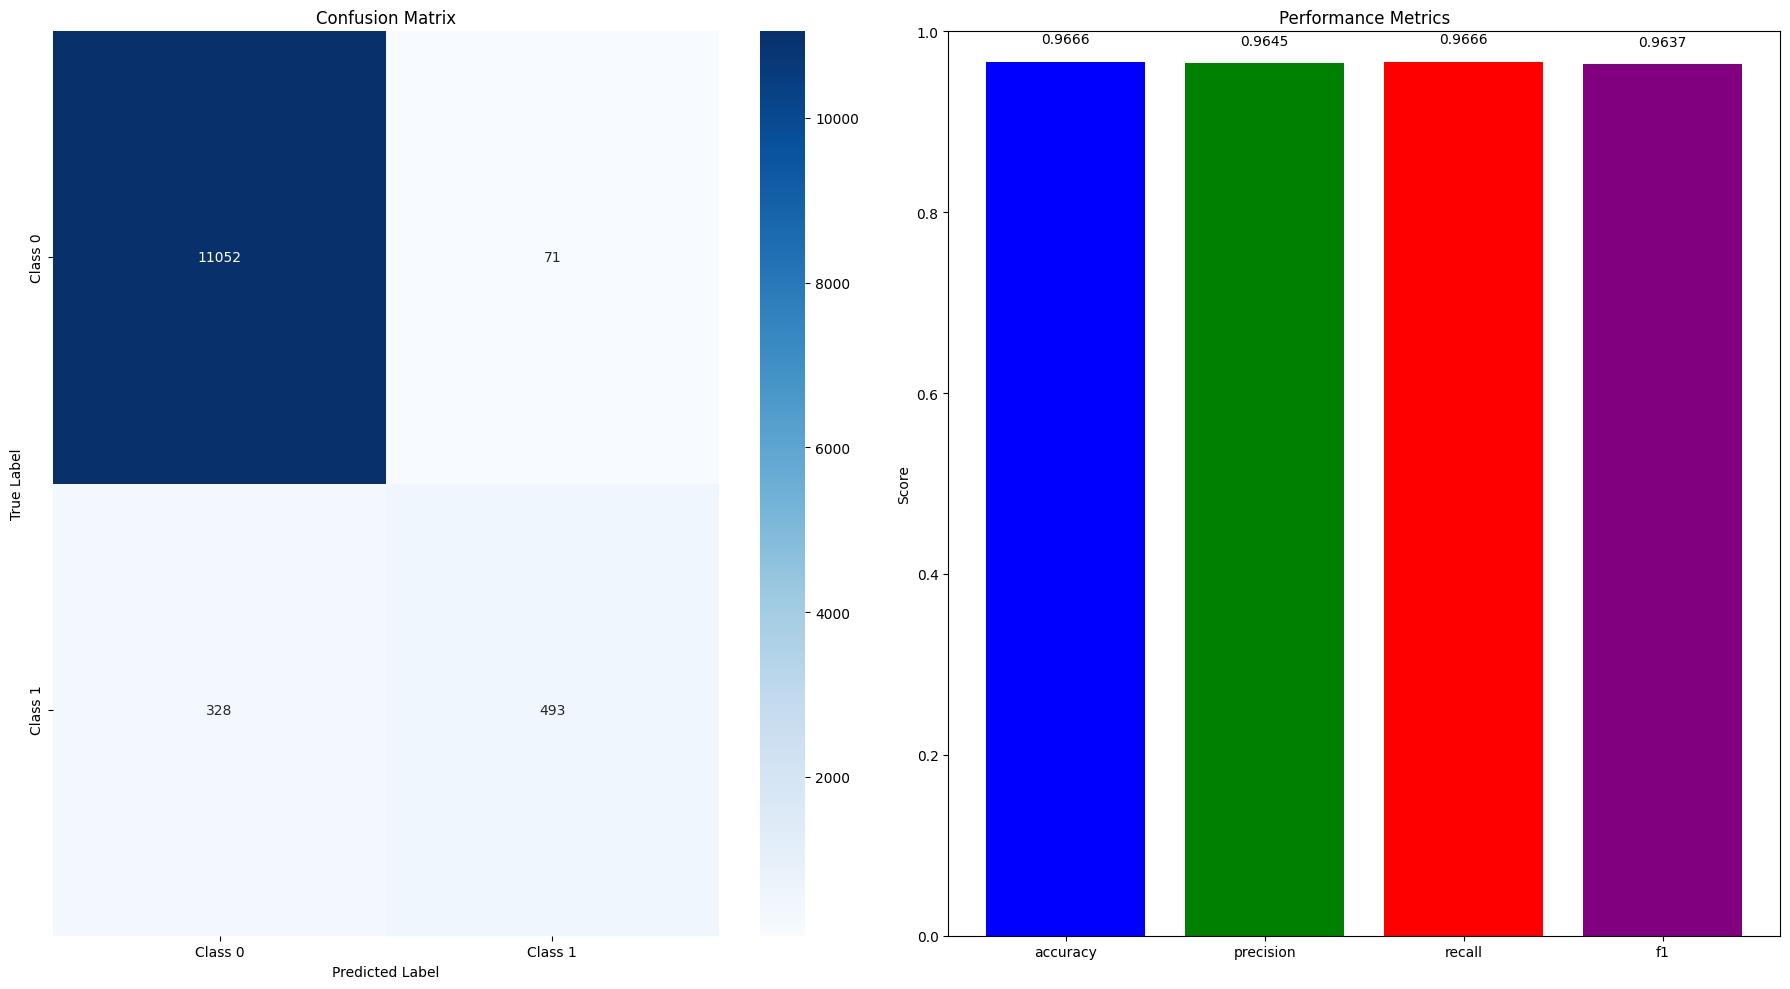

Saved predictions to test_predictions.csv


In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, mean_squared_error, mean_absolute_error, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.amp import autocast, GradScaler
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Định nghĩa lại mô hình để tải trọng số
class HybridGATGCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=8, dropout=0.27):
        super(HybridGATGCN, self).__init__()
        self.dropout = dropout

        # Layer 1
        self.gcn1 = GCNConv(in_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.gat1 = GATConv(hidden_dim, hidden_dim, heads=heads, concat=False, dropout=dropout)

        # Layer 2
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)
        self.gat2 = GATConv(hidden_dim, out_dim, heads=heads, concat=False, dropout=dropout)

    def forward(self, x, edge_index):
        # Layer 1
        x = self.gcn1(x, edge_index)
        x = self.bn1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)
        x = self.gat1(x, edge_index)

        # Layer 2
        x = torch.nn.functional.relu(x)
        x = self.gcn2(x, edge_index)
        x = self.bn2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)

        return torch.nn.functional.log_softmax(x, dim=1)

def load_test_data(file_path):
    """
    Tải dữ liệu kiểm thử từ file CSV
    """
    try:
        df = pd.read_csv(file_path)
        if 'label' not in df.columns:
            raise ValueError("Không tìm thấy cột 'label' trong dữ liệu")

        labels = df.pop('label').values
        features = df.values

        return features, labels
    except Exception as e:
        print(f"Lỗi khi tải dữ liệu: {e}")
        raise

def create_test_graph(features, labels, n_neighbors=5):
    """
    Tạo đồ thị kiểm thử từ features và labels
    """
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(features)
    knn_adj = nbrs.kneighbors_graph(features, mode='connectivity')
    edge_index = np.array(knn_adj.nonzero())
    edge_index = torch.tensor(edge_index, dtype=torch.long)

    x_tensor = torch.tensor(features, dtype=torch.float32)
    y_tensor = torch.tensor(labels, dtype=torch.long)

    test_mask = torch.ones(x_tensor.shape[0], dtype=torch.bool)

    return Data(x=x_tensor, edge_index=edge_index, y=y_tensor, test_mask=test_mask)

def evaluate_model(model, data):
    """
    Đánh giá mô hình trên dữ liệu kiểm thử
    """
    device = data.x.device
    model.eval()
    with torch.no_grad():
        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            out = model(data.x, data.edge_index)
            pred = out.argmax(dim=1)

            correct = pred[data.test_mask] == data.y[data.test_mask]
            accuracy = correct.sum().item() / data.test_mask.sum().item()

            y_true = data.y[data.test_mask].cpu().numpy()
            y_pred = pred[data.test_mask].cpu().numpy()

            try:
                roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
            except:
                roc_auc = 0.0

            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mae = mean_absolute_error(y_true, y_pred)

            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

            cm = confusion_matrix(y_true, y_pred)

            probs = torch.exp(out)

            return {
                'accuracy': accuracy,
                'roc_auc': roc_auc,
                'rmse': rmse,
                'mae': mae,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'confusion_matrix': cm,
                'predictions': pred[data.test_mask].cpu().numpy(),
                'true_labels': y_true,
                'probabilities': probs[data.test_mask].cpu().numpy()
            }

def visualize_results(results, class_names=None):
    """
    Trực quan hóa kết quả kiểm thử
    """
    # Tạo figure với 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 10))

    cm = results['confusion_matrix']
    if class_names is None:
        class_names = [f'Class {i}' for i in range(cm.shape[0])]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
                yticklabels=class_names, ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # 2. Biểu đồ các chỉ số hiệu suất
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    values = [results[metric] for metric in metrics]

    axes[1].bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
    axes[1].set_title('Performance Metrics')
    axes[1].set_ylim(0, 1.0)
    axes[1].set_ylabel('Score')

    for i, v in enumerate(values):
        axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center')

    plt.tight_layout()
    plt.savefig('test_results.png')
    plt.show()

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    test_file_path = "preprocessed_data.csv"
    try:
        features, labels = load_test_data(test_file_path)
        print(f"Loaded test data: {features.shape[0]} samples, {features.shape[1]} features")
    except FileNotFoundError:
        print("Preprocessed data file not found. Please run the preprocessing step first.")
        return

    data = create_test_graph(features, labels)
    data = data.to(device)
    print(f"Created test graph with {data.x.shape[0]} nodes and {data.edge_index.shape[1]} edges")

    model_path = "/content/trained_model.pt"
    try:
        num_classes = 2
        model = HybridGATGCN(
            in_dim=features.shape[1],
            hidden_dim=256,  # Changed to 256 to match the saved model
            out_dim=num_classes,
            heads=8,  # Changed to 8 to match the saved model
            dropout=0.27
        ).to(device)

        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Loaded model from {model_path}")
    except FileNotFoundError:
        print(f"Không tìm thấy tệp mô hình {model_path}. Sử dụng mô hình chưa huấn luyện.")
        num_classes = len(np.unique(labels))
        model = HybridGATGCN(
            in_dim=features.shape[1],
            hidden_dim=128,
            out_dim=num_classes,
            heads=8,
            dropout=0.27
        ).to(device)

    results = evaluate_model(model, data)

    print("\nTest Results:")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"ROC-AUC: {results['roc_auc']:.4f}")
    print(f"RMSE: {results['rmse']:.4f}")
    print(f"MAE: {results['mae']:.4f}")
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"F1-score: {results['f1']:.4f}")

    class_names = [f'Class {i}' for i in range(results['confusion_matrix'].shape[0])]
    visualize_results(results, class_names)

    results_df = pd.DataFrame({
        'true_label': results['true_labels'],
        'predicted_label': results['predictions']
    })


    for i in range(results['probabilities'].shape[1]):
        results_df[f'prob_class_{i}'] = results['probabilities'][:, i]

    results_df.to_csv('test_predictions.csv', index=False)
    print(f"Saved predictions to test_predictions.csv")

if __name__ == "__main__":
    main()

#So sánh với Baseline

##GAT : Mendonça, R., Salazar, A., & Martinez, E. (2025). Graph-Based Deep Learning for E-Commerce Fraud Detection. Journal of Advances in Engineering and Technology, 2(1).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, mean_squared_error, mean_absolute_error
)

# 1. Load CSV
def load_data(path):
    df = pd.read_csv(path)
    labels = df.pop('label').values
    features = df.values
    return features, labels

# 2. Build graph using kNN
def create_graph(features, labels, k=5):
    nbrs = NearestNeighbors(n_neighbors=k).fit(features)
    edge_index = np.array(nbrs.kneighbors_graph(features, mode='connectivity').nonzero())
    edge_index = torch.tensor(edge_index, dtype=torch.long)

    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.long)

    num_nodes = x.shape[0]
    indices = torch.randperm(num_nodes)

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    num_train = int(0.7 * num_nodes)
    num_val = int(0.15 * num_nodes)

    train_mask[indices[:num_train]] = True
    val_mask[indices[num_train:num_train + num_val]] = True
    test_mask[indices[num_train + num_val:]] = True

    return Data(x=x, edge_index=edge_index, y=y,
                train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

# 3. Standard GAT model
class StandardGAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
        super(StandardGAT, self).__init__()
        self.dropout = dropout
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 4. Train
def train(model, data, epochs=100, lr=0.005):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    loss_fn = nn.NLLLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                pred = model(data.x, data.edge_index).argmax(dim=1)
                acc = accuracy_score(data.y[data.val_mask].cpu(), pred[data.val_mask].cpu())
                print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Val Accuracy: {acc:.4f}")

# 5. Evaluation
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        y_true = data.y[data.test_mask].cpu().numpy()
        y_pred = pred[data.test_mask].cpu().numpy()

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        try:
            roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
        except:
            roc_auc = 0.0
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)

        print("\nTest Results:")
        print(f"Accuracy:  {acc:.4f}")
        print(f"ROC-AUC:   {roc_auc:.4f}")
        print(f"RMSE:      {rmse:.4f}")
        print(f"MAE:       {mae:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-score:  {f1:.4f}")

        return {
            'accuracy': acc,
            'roc_auc': roc_auc,
            'rmse': rmse,
            'mae': mae,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

# 6. Run full pipeline
def run_gat_pipeline(csv_path="/content/preprocessed_data.csv"):
    print("Loading and processing data...")
    features, labels = load_data(csv_path)
    data = create_graph(features, labels)
    model = StandardGAT(
        in_channels=features.shape[1],
        hidden_channels=8,
        out_channels=len(np.unique(labels)),
        heads=8,
        dropout=0.6
    )
    print("Training GAT model...")
    train(model, data, epochs=100)
    print("Evaluating model...")
    metrics = evaluate(model, data)
    return model, metrics

# Run
if __name__ == "__main__":
    run_gat_pipeline("/content/preprocessed_data.csv")


Loading and processing data...
Training GAT model...
Epoch 000 | Loss: 0.8504 | Val Accuracy: 0.7052
Epoch 010 | Loss: 0.3967 | Val Accuracy: 0.9235
Epoch 020 | Loss: 0.3099 | Val Accuracy: 0.9235
Epoch 030 | Loss: 0.2803 | Val Accuracy: 0.9235
Epoch 040 | Loss: 0.2800 | Val Accuracy: 0.9235
Epoch 050 | Loss: 0.2633 | Val Accuracy: 0.9235
Epoch 060 | Loss: 0.2535 | Val Accuracy: 0.9235
Epoch 070 | Loss: 0.2437 | Val Accuracy: 0.9252
Epoch 080 | Loss: 0.2394 | Val Accuracy: 0.9313
Epoch 090 | Loss: 0.2419 | Val Accuracy: 0.9280
Epoch 099 | Loss: 0.2341 | Val Accuracy: 0.9397
Evaluating model...

Test Results:
Accuracy:  0.9526
ROC-AUC:   0.6247
RMSE:      0.2177
MAE:       0.0474
Precision: 0.9532
Recall:    0.9526
F1-score:  0.9392


##GCN : Asiri, A., & Somasundaram, K. (2025). Graph convolution network for fraud detection in bitcoin transactions. Scientific Reports, 15(1), 11076.

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, mean_squared_error, mean_absolute_error
)

# 1. Load và xử lý dữ liệu
def load_graph_data(path):
    df = pd.read_csv(path)
    y = df.pop('label').values
    X = df.values

    # Chuẩn hóa
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Chuyển dữ liệu về tensor
    x = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)

    # Giả lập graph fully connected (giảm RAM bằng cách random 1 phần)
    edge_index = torch.combinations(torch.arange(x.size(0)), r=2).t()
    edge_index = edge_index[:, torch.randperm(edge_index.size(1))[:min(5000, edge_index.size(1))]]

    return x, y, edge_index

# 2. Định nghĩa mô hình GCN
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# 3. Huấn luyện GCN
def train(model, data, train_idx, val_idx, epochs=100, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs+1):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[train_idx], data.y[train_idx])
        loss.backward()
        optimizer.step()

        if epoch == 1 or epoch % 10 == 0:
            model.eval()
            val_loss = criterion(out[val_idx], data.y[val_idx]).item()
            print(f"Epoch {epoch:03d} - Val Loss: {val_loss:.4f}")

# 4. Đánh giá mô hình
def evaluate(model, data, test_idx):
    model.eval()
    out = model(data)
    preds = out[test_idx].argmax(dim=1).cpu().numpy()
    y_true = data.y[test_idx].cpu().numpy()

    acc = accuracy_score(y_true, preds)
    f1 = f1_score(y_true, preds, average='weighted')
    precision = precision_score(y_true, preds, average='weighted', zero_division=0)
    recall = recall_score(y_true, preds, average='weighted', zero_division=0)
    try:
        roc_auc = roc_auc_score(y_true, preds, multi_class='ovr')
    except:
        roc_auc = 0.0
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    mae = mean_absolute_error(y_true, preds)

    print("\nTest Results:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print(f"RMSE:      {rmse:.4f}")
    print(f"MAE:       {mae:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")

# 5. Chạy toàn bộ pipeline
def run_pipeline(path="/content/preprocessed_data.csv"):
    x, y, edge_index = load_graph_data(path)
    num_classes = len(np.unique(y))

    # Train/Val/Test split
    idx = np.arange(len(y))
    train_idx, temp_idx, y_train, y_temp = train_test_split(idx, y, test_size=0.3, stratify=y, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=y_temp, random_state=42)

    # Đóng gói dữ liệu vào dạng Data
    data = Data(x=x, edge_index=edge_index, y=y)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data = data.to(device)

    model = GCN(input_dim=x.size(1), hidden_dim=64, output_dim=num_classes).to(device)
    train_idx = torch.tensor(train_idx, dtype=torch.long).to(device)
    val_idx = torch.tensor(val_idx, dtype=torch.long).to(device)
    test_idx = torch.tensor(test_idx, dtype=torch.long).to(device)

    print("Training GCN model...")
    train(model, data, train_idx, val_idx, epochs=100, lr=0.001)

    print("Evaluating GCN model...")
    evaluate(model, data, test_idx)

if __name__ == "__main__":
    run_pipeline("/content/preprocessed_data.csv")


Training GCN model...
Epoch 001 - Val Loss: 0.7138
Epoch 010 - Val Loss: 0.4526
Epoch 020 - Val Loss: 0.3212
Epoch 030 - Val Loss: 0.2610
Epoch 040 - Val Loss: 0.2488
Epoch 050 - Val Loss: 0.2359
Epoch 060 - Val Loss: 0.2240
Epoch 070 - Val Loss: 0.2310
Epoch 080 - Val Loss: 0.2191
Epoch 090 - Val Loss: 0.2190
Epoch 100 - Val Loss: 0.2233
Evaluating GCN model...

Test Results:
Accuracy:  0.9353
ROC-AUC:   0.5548
RMSE:      0.2544
MAE:       0.0647
Precision: 0.9198
Recall:    0.9353
F1-score:  0.9133


##CNN : NAGARAJU, M., Babu, P. N., Ravipati, V. S. P., & Chaitanya, V. (2024). UPI fraud detection using convolutional neural networks (CNN).

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, mean_squared_error, mean_absolute_error
)
from torch.utils.data import Dataset, DataLoader

# 1. Custom Dataset
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # shape: (batch, 1, features)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 2. CNN Model
class TabularCNN(nn.Module):
    def __init__(self, input_length, num_classes):
        super(TabularCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # shape: (batch, 16, L)
        x = F.relu(self.conv2(x))  # shape: (batch, 32, L)
        x = self.pool(x).squeeze(-1)  # shape: (batch, 32)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# 3. Evaluation
def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            preds = model(X_batch).argmax(dim=1)
            all_preds.append(preds)
            all_labels.append(y_batch)
    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    try:
        roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
    except:
        roc_auc = 0.0
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    print("\nTest Results:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print(f"RMSE:      {rmse:.4f}")
    print(f"MAE:       {mae:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")

# 4. Main pipeline
def run_cnn_pipeline(path="/content/preprocessed_data.csv"):
    # Load and preprocess
    df = pd.read_csv(path)
    y = df.pop('label').values
    X = df.values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    num_classes = len(np.unique(y))
    input_length = X.shape[1]

    # Split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    # Create datasets
    train_set = TabularDataset(X_train, y_train)
    val_set = TabularDataset(X_val, y_val)
    test_set = TabularDataset(X_test, y_test)

    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)

    # Model
    model = TabularCNN(input_length=input_length, num_classes=num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.NLLLoss()

    # Training loop
    for epoch in range(1, 51):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 10 == 0:
            print(f"Epoch {epoch} - Loss: {total_loss:.4f}")

    # Evaluation
    evaluate_model(model, test_loader)

    return model

# Run
if __name__ == "__main__":
    run_cnn_pipeline("/content/preprocessed_data.csv")


Epoch 10 - Loss: 41.0824
Epoch 20 - Loss: 37.3934
Epoch 30 - Loss: 34.2447
Epoch 40 - Loss: 32.6094
Epoch 50 - Loss: 31.2839

Test Results:
Accuracy:  0.9604
ROC-AUC:   0.7302
RMSE:      0.1990
MAE:       0.0396
Precision: 0.9589
Recall:    0.9604
F1-score:  0.9542


##GAN : Zhu, M., Gong, Y., Xiang, Y., Yu, H., & Huo, S. (2024, June). Utilizing GANs for fraud detection: model training with synthetic transaction data. In International Conference on Image, Signal Processing, and Pattern Recognition (ISPP 2024) (Vol. 13180, pp. 887-894). SPIE.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, mean_squared_error, mean_absolute_error
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.ensemble import RandomForestClassifier

# 1. Load & preprocess data
def load_data(path):
    df = pd.read_csv(path)
    labels = df.pop('label').values
    features = df.values
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    return torch.tensor(features, dtype=torch.float32), torch.tensor(labels, dtype=torch.long), scaler

# 2. Generator
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim, label_dim, output_dim):
        super().__init__()
        self.label_dim = label_dim # Pass label_dim to the constructor and store it as an attribute
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, z, labels):
        one_hot = torch.nn.functional.one_hot(labels, num_classes=self.label_dim).float() # Access label_dim using self.label_dim
        x = torch.cat([z, one_hot], dim=1)
        return self.model(x)

# 3. Discriminator
class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_dim, label_dim):
        super().__init__()
        self.label_dim = label_dim # Pass label_dim to the constructor and store it as an attribute
        self.model = nn.Sequential(
            nn.Linear(input_dim + label_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        one_hot = torch.nn.functional.one_hot(labels, num_classes=self.label_dim).float() # Access label_dim using self.label_dim
        x = torch.cat([x, one_hot], dim=1)
        return self.model(x)

# 3. Discriminator
class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_dim, label_dim):
        super().__init__()
        self.label_dim = label_dim  # Store label_dim as an attribute
        self.model = nn.Sequential(
            nn.Linear(input_dim + label_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        one_hot = torch.nn.functional.one_hot(labels, num_classes=self.label_dim).float()  # Access label_dim using self.label_dim
        x = torch.cat([x, one_hot], dim=1)
        return self.model(x)

# 4. Training
def train_cgan(X_train, y_train, noise_dim=32, epochs=200, batch_size=64, lr=0.0002):
    input_dim = X_train.shape[1]
    label_dim = len(torch.unique(y_train))

    G = ConditionalGenerator(noise_dim, label_dim, input_dim)
    D = ConditionalDiscriminator(input_dim, label_dim)

    opt_G = optim.Adam(G.parameters(), lr=lr)
    opt_D = optim.Adam(D.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    dataset = TensorDataset(X_train, y_train)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print("Training Conditional GAN...")
    for epoch in range(1, epochs + 1):
        for real_x, real_y in loader:
            batch_size = real_x.size(0)
            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)

            # Train Discriminator
            z = torch.randn(batch_size, noise_dim)
            gen_x = G(z, real_y)
            d_real = D(real_x, real_y)
            d_fake = D(gen_x.detach(), real_y)

            d_loss = loss_fn(d_real, real_labels) + loss_fn(d_fake, fake_labels)
            opt_D.zero_grad()
            d_loss.backward()
            opt_D.step()

            # Train Generator
            z = torch.randn(batch_size, noise_dim)
            gen_x = G(z, real_y)
            d_out = D(gen_x, real_y)
            g_loss = loss_fn(d_out, real_labels)

            opt_G.zero_grad()
            g_loss.backward()
            opt_G.step()

        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch [{epoch}/{epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")

    return G, D

# 5. Generate synthetic data
def generate_synthetic_data(generator, noise_dim, num_samples_per_class, num_classes):
    all_fake = []
    all_labels = []

    for label in range(num_classes):
        z = torch.randn(num_samples_per_class, noise_dim)
        labels = torch.full((num_samples_per_class,), label, dtype=torch.long)
        fake = generator(z, labels).detach().numpy()
        all_fake.append(fake)
        all_labels.append(labels.numpy())

    X_fake = np.vstack(all_fake)
    y_fake = np.concatenate(all_labels)
    return X_fake, y_fake

# 6. Evaluation
def evaluate_on_real_test(X_fake, y_fake, X_test, y_test):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_fake, y_fake)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    try:
        roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    except:
        roc_auc = 0.0
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print("\nTest Results:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print(f"RMSE:      {rmse:.4f}")
    print(f"MAE:       {mae:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")

    return {
        "accuracy": acc,
        "roc_auc": roc_auc,
        "rmse": rmse,
        "mae": mae,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

# 7. Main pipeline
def run_cgan_pipeline(path="/content/preprocessed_data.csv"):
    X, y, scaler = load_data(path)
    num_classes = len(torch.unique(y))

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    G, D = train_cgan(X_train, y_train, noise_dim=32, epochs=200, batch_size=64)

    # Generate synthetic training data
    X_fake, y_fake = generate_synthetic_data(G, noise_dim=32, num_samples_per_class=200, num_classes=num_classes)

    # Evaluate on real test data
    metrics = evaluate_on_real_test(X_fake, y_fake, X_test.numpy(), y_test.numpy())

    return G, D, metrics

# Run
if __name__ == "__main__":
    run_cgan_pipeline("/content/preprocessed_data.csv")


Training Conditional GAN...
Epoch [1/200]  D_loss: 0.9868  G_loss: 0.9018
Epoch [20/200]  D_loss: 0.3193  G_loss: 2.9858
Epoch [40/200]  D_loss: 0.5043  G_loss: 2.2016
Epoch [60/200]  D_loss: 1.0039  G_loss: 1.4701
Epoch [80/200]  D_loss: 1.0260  G_loss: 1.1072
Epoch [100/200]  D_loss: 1.0053  G_loss: 1.1902
Epoch [120/200]  D_loss: 1.1106  G_loss: 1.0627
Epoch [140/200]  D_loss: 1.0043  G_loss: 0.9764
Epoch [160/200]  D_loss: 1.0867  G_loss: 0.9068
Epoch [180/200]  D_loss: 1.0730  G_loss: 0.9539
Epoch [200/200]  D_loss: 1.0944  G_loss: 0.9467

Test Results:
Accuracy:  0.8569
ROC-AUC:   0.7932
RMSE:      0.3783
MAE:       0.1431
Precision: 0.9292
Recall:    0.8569
F1-score:  0.8836
